In [1]:
import tidy3d as td
import tidy3d.plugins.adjoint as tda
from tidy3d.plugins.adjoint.web import run_local as run

In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
import jax
import jax.numpy as jnp

In [4]:
wavelength = 1.0
freq0 = td.C_0 / wavelength

fwidth = freq0 / 10
num_freqs = 10
freqs = np.linspace(freq0 - fwidth/2, freq0 + fwidth/2, num_freqs)

num_pts = 40
angles = np.linspace(0, np.pi/2, num_pts + 2)[1:-1]

n_wg = 2.0

spc = 1 * wavelength
t = 1 * wavelength
mode_spc = t / 2.0

wmid = 0.6 * wavelength
wmax = 0.9 * wavelength
wmin = 0.3 * wavelength

radius = 3 * wavelength

monitor_name = "mode"

min_steps_per_wvl = 25

In [5]:
Lx = Ly = t + radius + abs(wmax - wmid) + spc
Lz = 0

In [6]:
def thickness(param: float) -> float:
    param_01 = (jnp.tanh(param) + 1.0) / 2.0
    return wmax * param_01 + wmin * (1 - param_01)

In [7]:
def make_vertices(params):
    vertices = []
    vertices.append((-Lx/2 + t, -Ly/2 + t + radius + wmid/2))
    for angle, param in zip(angles, params):
        thickness_i = thickness(param)
        radius_i = radius + thickness_i/2.0
        x = radius_i * np.sin(angle) -Lx/2 + t
        y = radius_i * np.cos(angle) -Ly/2 + t
        vertices.append((x, y))
    vertices.append((-Lx/2 + t + radius + wmid/2, -Ly/2 + t))
    vertices.append((-Lx/2 + t + radius - wmid/2, -Ly/2 + t))
    for angle, param in zip(angles[::-1], params[::-1]):
        thickness_i = thickness(param)
        radius_i = radius - thickness_i/2.0
        x = radius_i * np.sin(angle) -Lx/2 + t
        y = radius_i * np.cos(angle) -Ly/2 + t
        vertices.append((x, y))    
    vertices.append((-Lx/2 + t, -Ly/2 + t + radius - wmid/2))
    return vertices
        


In [8]:
params = 0 * np.random.random(num_pts) - 0.5 * 0
vertices = make_vertices(params)

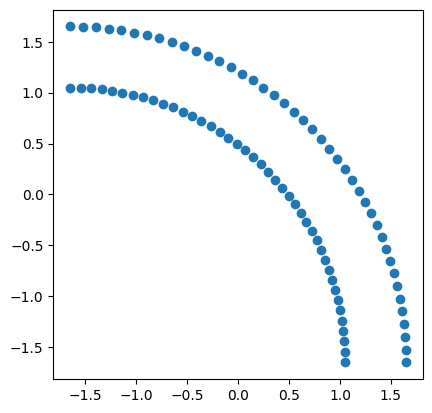

In [9]:
plt.scatter(*np.array(vertices).T)
ax = plt.gca()
ax.set_aspect("equal")

In [10]:
def make_polyslab(params) -> tda.JaxPolySlab:
    vertices = make_vertices(params)
    return tda.JaxPolySlab(
        vertices=vertices,
        slab_bounds=(-1,1),
        axis=2,
    )    

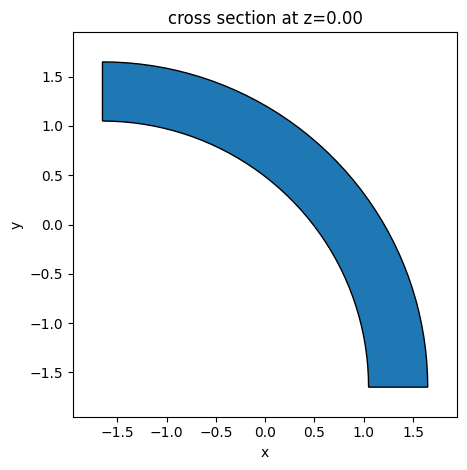

In [11]:
polyslab = make_polyslab(params)
ax = polyslab.plot(z=0)

In [12]:
def make_input_structures(params) -> list[tda.JaxPolySlab]:
    polyslab = make_polyslab(params)
    medium = tda.JaxMedium(permittivity=n_wg**2)
    return [tda.JaxStructure(geometry=polyslab, medium=medium)]

box_in = td.Box.from_bounds(
    rmin=(-Lx/2 - 1, -Ly/2 + t + radius - wmid/2, -1),
    rmax=(-Lx/2 + t, -Ly/2 + t + radius + wmid/2, +1),
)
box_out = td.Box.from_bounds(
    rmin=(-Lx/2 + t + radius - wmid/2, -Ly/2 - 1, -1),
    rmax=(-Lx/2 + t + radius + wmid/2, -Ly/2 + t, +1),
)
wg_in = td.Structure(geometry=box_in, medium=td.Medium(permittivity=n_wg**2))
wg_out = td.Structure(geometry=box_out, medium=td.Medium(permittivity=n_wg**2))


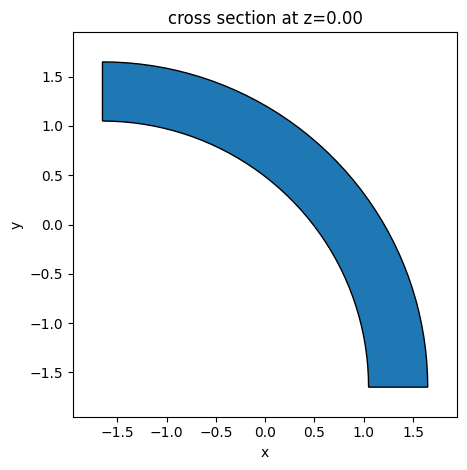

In [13]:
(ring,) = input_structures = make_input_structures(params)
ax = ring.plot(z=0)

In [14]:
mode_size = wmax * 4

mode_src = td.ModeSource(
    size=(0, mode_size, 1),
    center=(-Lx/2 + t/2, -Ly/2 + t + radius, 0),
    direction="+",
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    )
)

In [37]:
mode_mnt = td.ModeMonitor(
    size=(mode_size, 0, 1),
    center=(-Lx/2 + t + radius, -Ly/2 + t/2, 0),
    name=monitor_name,
    freqs=[freq0],
    mode_spec=td.ModeSpec(),
)

flux_mnt = td.FluxMonitor(
    size=(mode_size, 0, 1),
    center=(-Lx/2 + t + radius, -Ly/2 + t/2, 0),
    name="flux",
    freqs=[freq0],
)

mode_mnt_bb = td.ModeMonitor(
    size=(mode_size, 0, 1),
    center=(-Lx/2 + t + radius, -Ly/2 + t/2, 0),
    name="mode_bb",
    freqs=freqs.tolist(),
    mode_spec=td.ModeSpec(),
)

fld_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field",
)

In [38]:

def make_sim(params, use_fld_mnt: bool = True) -> tda.JaxSimulation:
    monitors = [mode_mnt_bb, flux_mnt]
    if use_fld_mnt:
        monitors += [fld_mnt]
    input_structures = make_input_structures(params)
    return tda.JaxSimulation(
        size=(Lx, Ly, Lz),
        input_structures=input_structures,
        structures=[wg_in, wg_out],
        sources=[mode_src],
        output_monitors=[mode_mnt],
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
        monitors=monitors,
        run_time = 10/fwidth,
)

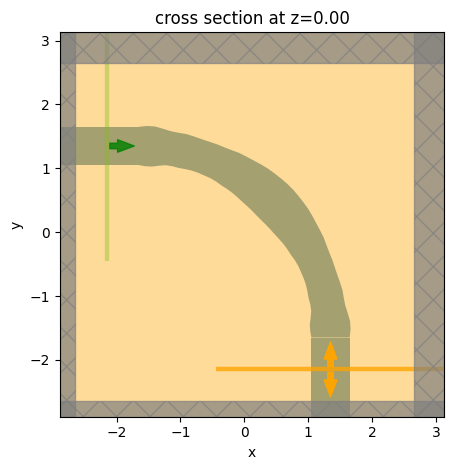

In [39]:
sim = make_sim(params)
ax = sim.plot(z=0)

In [40]:
from tidy3d.plugins.adjoint.utils.penalty import RadiusPenalty

penalty = RadiusPenalty(min_radius=0.150, alpha=1.0, kappa=10.0)


In [41]:
def objective(params, use_fld_mnt:bool = True):
    sim = make_sim(params, use_fld_mnt=use_fld_mnt)
    sim_data = run(sim, task_name='bend', verbose=False)
    amps = sim_data[monitor_name].amps.sel(direction="-").values
    transmission = jnp.abs(jnp.array(amps))**2
    vertices = make_vertices(params)
    J = jnp.sum(transmission) - penalty.evaluate(vertices)
    aux = sim_data
    return J, aux

In [42]:
val_grad = jax.value_and_grad(objective, has_aux=True)

In [43]:
(val, sim_data), grad = val_grad(params)

In [44]:
print(val)
print(grad)

1.9503042
[-0.05858074 -0.07795998  0.03173087  0.11858104  0.11993693 -0.0088233
  0.0351858   0.04803228  0.04292742  0.00293401  0.07127286  0.06383228
 -0.03346517  0.02902183  0.03600139 -0.00550967 -0.02369489 -0.00577402
 -0.02729645 -0.03791397 -0.03845479 -0.02844733 -0.00660656 -0.02536319
 -0.00716607  0.0361494   0.03120991 -0.03293027  0.06534214  0.06797388
  0.00180159  0.04075827  0.04901138  0.03759382 -0.00968324  0.12431655
  0.1211583   0.02461587 -0.08009063 -0.04778386]


In [45]:
sim_data["flux"]

FluxData(type='FluxData', monitor=FluxMonitor(type='FluxMonitor', center=(1.35, -2.15, 0.0), size=(3.6, 0.0, 1.0), name='flux', freqs=(299792458000000.0,), apodization=ApodizationSpec(start=None, end=None, width=None, type='ApodizationSpec'), normal_dir='+', exclude_surfaces=None), flux=<xarray.FluxDataArray (f: 1)>
array([-1.9908794], dtype=float32)
Coordinates:
  * f        (f) float64 2.998e+14
Attributes:
    units:      W
    long_name:  flux)

In [30]:
import optax

# turn off warnings to reduce verbosity
td.config.logging_level='ERROR'

# hyperparameters
num_steps = 11
learning_rate = 0.2

# initialize adam optimizer with starting parameters
params = np.array(params).copy()
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
objective_history = []
param_history = [params]
data_history = []

for i in range(num_steps):

    # compute gradient and current objective funciton value
    (value, sim_data), gradient = val_grad(params)
    
    # convert nan to 0 (infinite radius of curvature) and multiply all by -1 to maximize obj_fn.
    gradient = -1 * np.nan_to_num(np.array(gradient.copy()))

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # save history
    objective_history.append(value)
    param_history.append(params)
    data_history.append(sim_data)


step = 1
	J = 1.7155e+00
	grad_norm = 7.5847e-01
step = 2
	J = 1.8697e+00
	grad_norm = 3.4092e-01
step = 3
	J = 1.7683e+00
	grad_norm = 6.9553e-01
step = 4
	J = 1.8082e+00
	grad_norm = 6.7160e-01
step = 5
	J = 1.9228e+00
	grad_norm = 4.1994e-01
step = 6
	J = 1.9384e+00
	grad_norm = 4.5105e-01
step = 7
	J = 1.9104e+00
	grad_norm = 5.0995e-01
step = 8
	J = 1.8934e+00
	grad_norm = 5.3375e-01
step = 9
	J = 1.9237e+00
	grad_norm = 4.3359e-01
step = 10
	J = 1.9617e+00
	grad_norm = 2.9854e-01
step = 11
	J = 1.9649e+00
	grad_norm = 2.8067e-01


In [31]:
sim_start = make_sim(param_history[0])
data_start = data_history[0]

sim_final = make_sim(param_history[-1])
data_final = data_history[-1]


<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

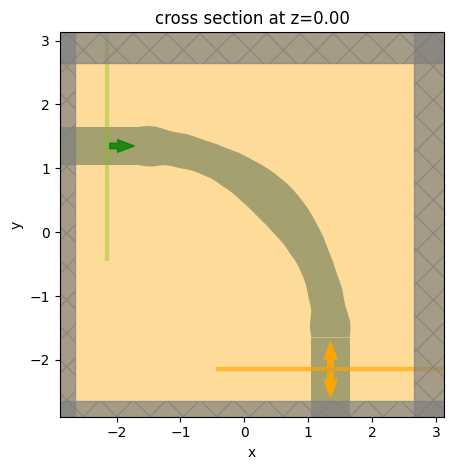

In [32]:
sim_final.plot(z=0)

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

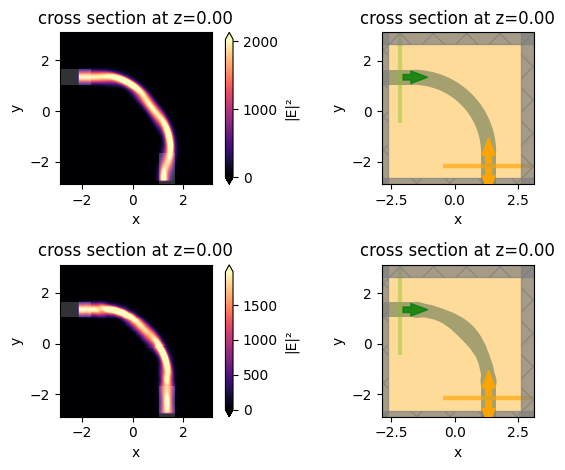

In [33]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True)

data_start.plot_field('field', 'E', 'abs^2', ax=ax1)
sim_start.plot(z=0, ax=ax2)

data_final.plot_field('field', 'E', 'abs^2', ax=ax3)
sim_final.plot(z=0, ax=ax4)


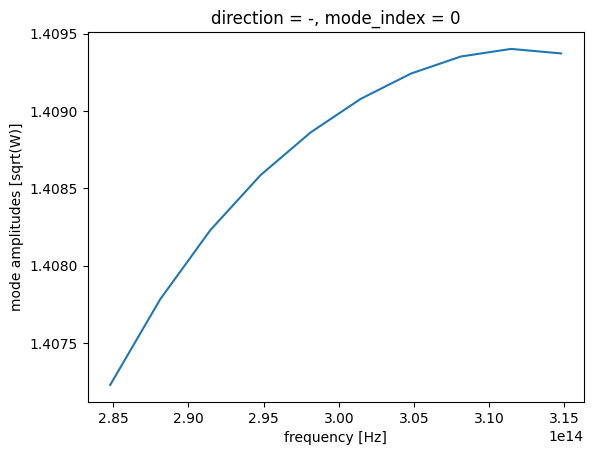

In [34]:
amp_bb = sim_data['mode_bb'].amps.sel(direction="-")
abs(amp_bb).plot(x="f")

In [35]:
amp_bb

<xarray.ModeAmpsDataArray (f: 10, mode_index: 1)>
array([[ 0.62156398-1.2625191j ],
       [ 1.3548767 -0.38231716j],
       [ 1.19055281+0.75212942j],
       [ 0.2365591 +1.38857962j],
       [-0.87493918+1.10425236j],
       [-1.40639191+0.08697544j],
       [-1.00444059-0.9884644j ],
       [ 0.0646853 -1.40786754j],
       [ 1.09114413-0.89208606j],
       [ 1.39262478+0.21662666j]])
Coordinates:
    direction   <U1 '-'
  * f           (f) float64 2.848e+14 2.881e+14 ... 3.115e+14 3.148e+14
  * mode_index  (mode_index) int64 0
Attributes:
    units:      sqrt(W)
    long_name:  mode amplitudes